**영어를 독일어로 번역하는 Transformer 구현**

In [ ]:
pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.7.0/de_core_news_sm-3.7.0-py3-none-any.whl (14.6 MB)
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

spacy_en = spacy.load('en_core_web_sm')  # English tokenization
spacy_de = spacy.load('de_core_news_sm')  # German tokenization

# 독일어(Deutsch) 문장을 토큰화
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# 영어(English) 문장을 토큰화
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


영어 -> 독일어로 번역하므로 Source가 tokenize_en, Target이 tokenize_de

In [ ]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

In [ ]:
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.de.gz
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.de.gz
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.en.gz
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.de.gz
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.en.gz

!gunzip train.de.gz
!gunzip train.en.gz
!gunzip val.de.gz
!gunzip val.en.gz
!gunzip test_2016_flickr.de.gz
!gunzip test_2016_flickr.en.gz

# 정확한 경로와 파일 이름 설정
!mkdir -p .data/multi30k
!mv train.de .data/multi30k/train.de
!mv train.en .data/multi30k/train.en
!mv val.de .data/multi30k/val.de
!mv val.en .data/multi30k/val.en
!mv test_2016_flickr.de .data/multi30k/test2016.de
!mv test_2016_flickr.en .data/multi30k/test2016.en

--2024-12-14 06:40:07--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.de.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 637044 (622K) [application/octet-stream]
Saving to: ‘train.de.gz’

train.de.gz         100%[===================>] 622.11K  --.-KB/s    in 0.07s   

2024-12-14 06:40:07 (8.14 MB/s) - ‘train.de.gz’ saved [637044/637044]

--2024-12-14 06:40:07--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5

In [ ]:
from torchtext.datasets import Multi30k

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".en", ".de"), fields=(SRC, TRG))
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


영어 -> 독일어

In [ ]:
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']
['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']


In [ ]:
# build_vocab: 영어/독어 사전 생성
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 5893
len(TRG): 7853


In [ ]:
print(TRG.vocab.stoi["abcabc"]) # TRG.vocab: 단어 집
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1 # 의미없는 공간값
print(TRG.vocab.stoi["<sos>"]) # <sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <eos>: 3

print(TRG.vocab.stoi["ein"]) # 실제 존재하는 단어의 인덱스
print(TRG.vocab.stoi["ich"])

0
1
2
3
5
1180


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device = device)

In [ ]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg
    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    break

첫 번째 배치 크기: torch.Size([128, 41])
인덱스 0: 2
인덱스 1: 7
인덱스 2: 53
인덱스 3: 33
인덱스 4: 10
인덱스 5: 32
인덱스 6: 8
인덱스 7: 21
인덱스 8: 145
인덱스 9: 144
인덱스 10: 11
인덱스 11: 292
인덱스 12: 4
인덱스 13: 158
인덱스 14: 3
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1
인덱스 27: 1
인덱스 28: 1
인덱스 29: 1
인덱스 30: 1
인덱스 31: 1
인덱스 32: 1
인덱스 33: 1
인덱스 34: 1
인덱스 35: 1
인덱스 36: 1
인덱스 37: 1
인덱스 38: 1
인덱스 39: 1
인덱스 40: 1


In [ ]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim] # query_len는 단어의 개수
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산 # 행렬곱
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기 -> softmax에 영향을 미치지 않도록 하기 위해
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값 , 에너지값을 softmax
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산, Value랑 행렬곱함
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim) #입력차원과 출력차원이 hidden dimension으로 동일

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask) #입력값 src를 똑같이 복제해서 Q, K, V로 넣어줌

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0] # 문장의개수
        src_len = src.shape[1] # 각 문장 중에서 단어의 개수가 가장 많은 문장의 단어 개수

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim) #output_dim은 단어의 개수 이걸 임베딩 dim으로 바꿔줌
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

In [ ]:
INPUT_DIM = len(SRC.vocab) # 소스 언어의 개수
OUTPUT_DIM = len(TRG.vocab) # 타켓 언어의 개수
HIDDEN_DIM = 256 # 임베딩 차원 설정
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT,device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT,device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,542,061 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(5893, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
     

In [ ]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/transformer_english_to_german.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 8s
	Train Loss: 2.833 | Train PPL: 17.001
	Validation Loss: 2.336 | Validation PPL: 10.337
Epoch: 02 | Time: 0m 8s
	Train Loss: 2.228 | Train PPL: 9.279
	Validation Loss: 1.959 | Validation PPL: 7.093
Epoch: 03 | Time: 0m 8s
	Train Loss: 1.853 | Train PPL: 6.381
	Validation Loss: 1.760 | Validation PPL: 5.812
Epoch: 04 | Time: 0m 8s
	Train Loss: 1.589 | Train PPL: 4.899
	Validation Loss: 1.615 | Validation PPL: 5.030
Epoch: 05 | Time: 0m 8s
	Train Loss: 1.383 | Train PPL: 3.989
	Validation Loss: 1.539 | Validation PPL: 4.661
Epoch: 06 | Time: 0m 8s
	Train Loss: 1.218 | Train PPL: 3.382
	Validation Loss: 1.508 | Validation PPL: 4.518
Epoch: 07 | Time: 0m 8s
	Train Loss: 1.083 | Train PPL: 2.953
	Validation Loss: 1.488 | Validation PPL: 4.429
Epoch: 08 | Time: 0m 8s
	Train Loss: 0.967 | Train PPL: 2.629
	Validation Loss: 1.489 | Validation PPL: 4.430
Epoch: 09 | Time: 0m 8s
	Train Loss: 0.870 | Train PPL: 2.386
	Validation Loss: 1.466 | Validation PPL: 4.333
Epoch: 1

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/transformer_english_to_german.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.490 | Test PPL: 4.438


<ipython-input-39-ef63ded9a509>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/transformer_english_to_german.pt'))

In [ ]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

**번역 결과**

In [ ]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
타겟 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
전체 소스 토큰: ['<sos>', 'a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']
소스 문장 인덱스: [2, 4, 496, 11, 44, 24, 1393, 304, 4, 369, 184, 57, 5, 3]
모델 출력 결과: eine mutter und ihr junger junge machen draußen ein <unk> . <eos>


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
타겟 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
전체 소스 토큰: ['<sos>', 'a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']
소스 문장 인덱스: [2, 4, 496, 11, 44, 24, 1393, 304, 4, 369, 184, 57, 5, 3]
모델 출력 결과: eine mutter und ihr junger junge machen draußen ein <unk> . <eos>


<ipython-input-42-8dbe449b1e4c>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
<ipython-input-42-8dbe449b1e4c>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)
<ipython-input-42-8dbe449b1e4c>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
<ipython-input-42-8dbe449b1e4c>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)
<ipython-input-42-8dbe449b1e4c>:20: UserWarning: set_ticklabels() shou

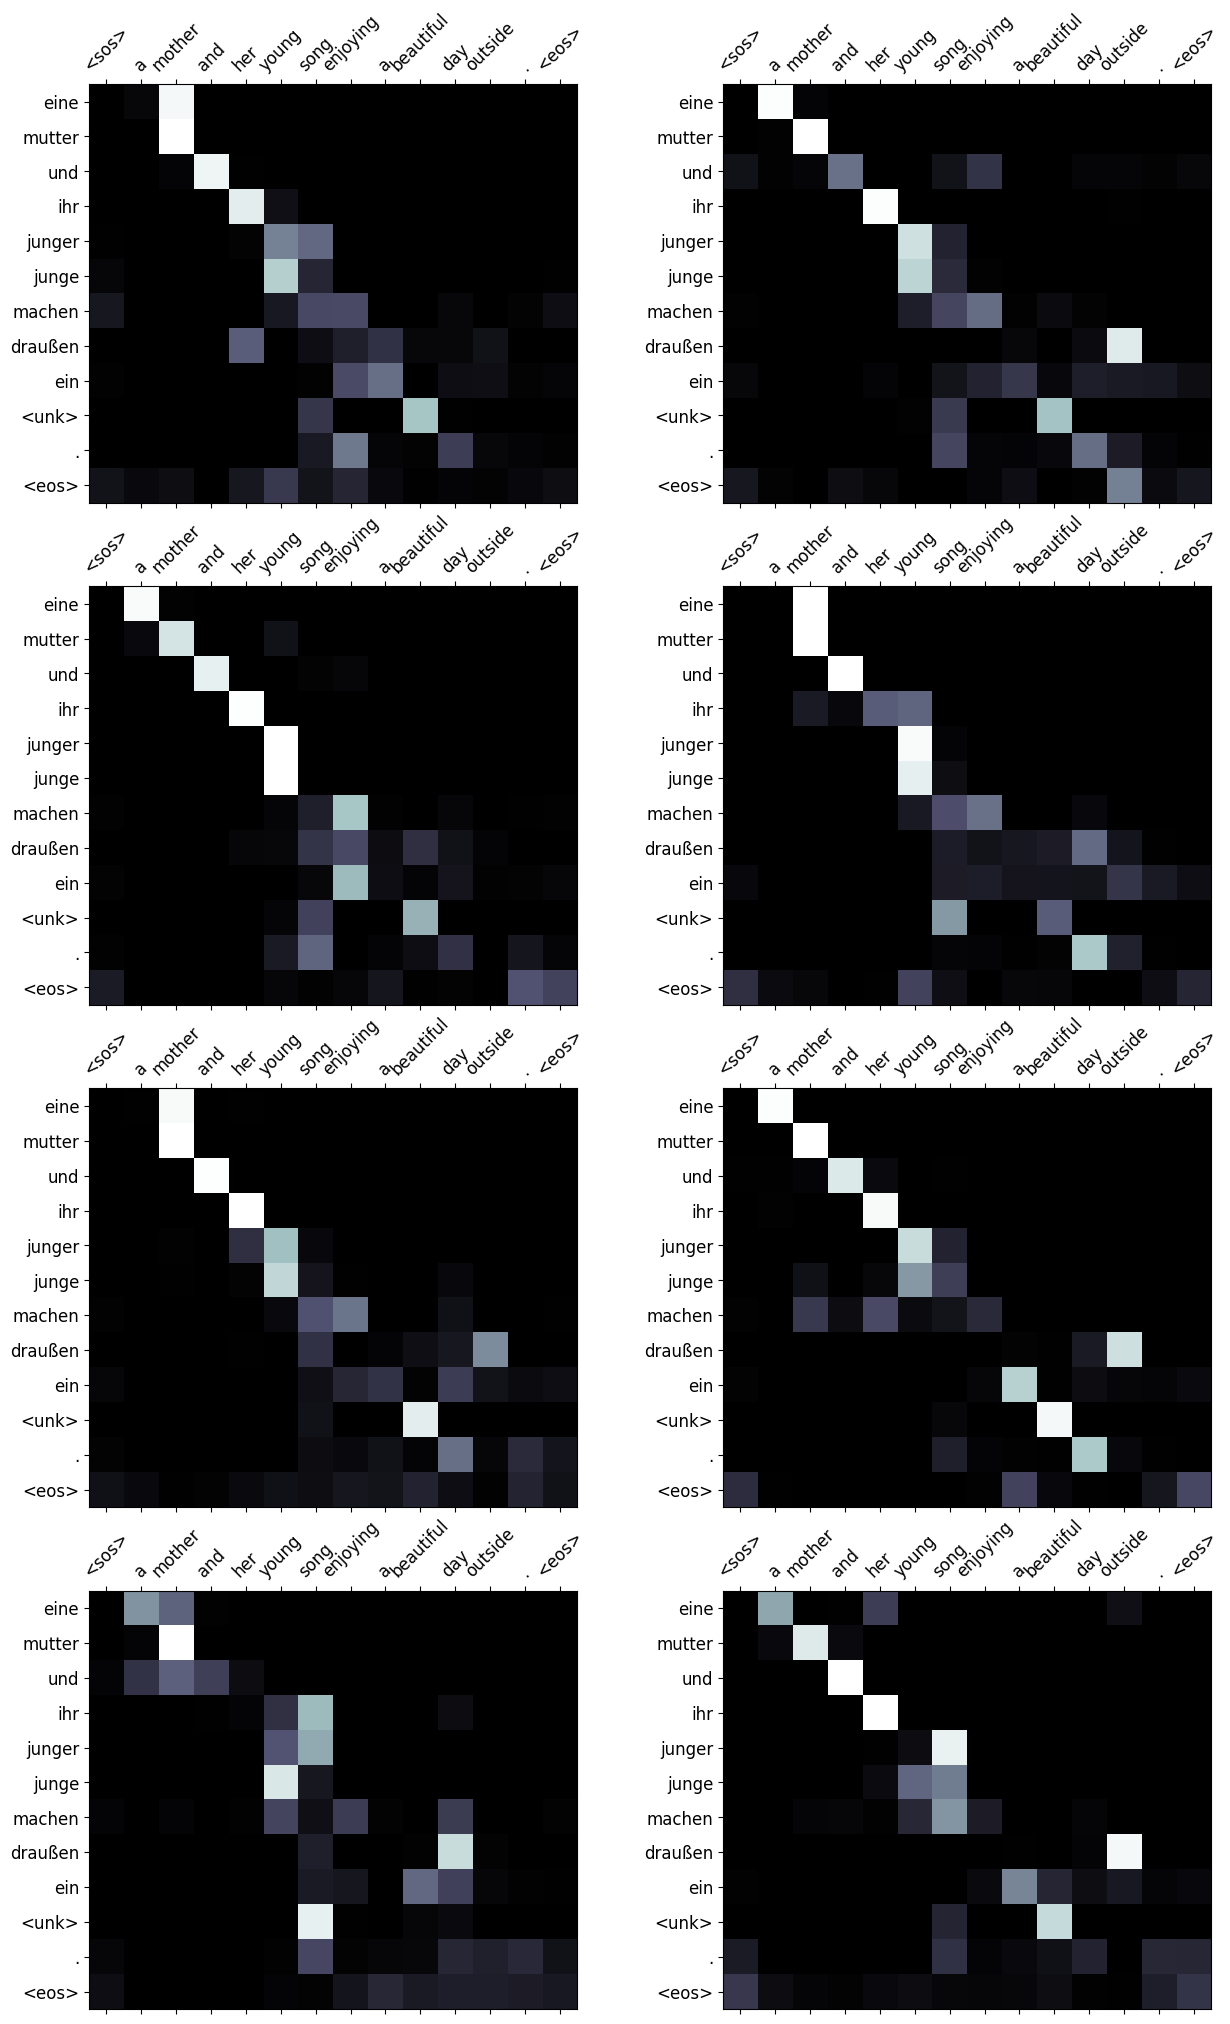

In [ ]:
display_attention(src, translation, attention)

In [ ]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}')
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}')
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}')
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}')

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}')
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}')
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}')
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}')

In [ ]:
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1000]
예측: ['eine', 'gruppe', 'von', 'soldaten', 'sitzt', 'auf', 'blauen', 'stühlen', 'in', 'blauen', 'stühlen', '.']
정답: ['eine', 'gruppe', 'überwiegend', 'asiatischer', 'kinder', 'sitzt', 'in', 'arbeitsnischen', 'verteilt', 'auf', 'blauen', 'stühlen', '.']
[200/1000]
예측: ['eine', 'gruppe', 'von', 'menschen', 'ist', 'ganz', 'mit', 'regenschirmen', 'bedeckt', '.']
정답: ['alle', 'personen', 'in', 'der', 'gruppe', 'stehen', 'unter', 'regenschirmen', '.']
[300/1000]
예측: ['ein', 'torhüter', 'auf', 'einem', 'gelben', 'feld', '<unk>', '.']
정답: ['ein', 'torwart', 'in', 'einem', 'gelben', 'trikot', 'schützt', 'das', 'tor', '.']
[400/1000]
예측: ['zwei', 'kleine', 'kinder', 'auf', 'sand', '.']
정답: ['zwei', 'kleine', 'kinder', 'auf', 'dem', 'sand', '.']
[500/1000]
예측: ['zwei', 'mittelgroße', 'hunde', 'laufen', 'über', 'den', 'schnee', '.']
정답: ['zwei', 'mittelgroße', 'hunde', 'laufen', 'über', 'den', 'schnee', '.']
[600/1000]
예측: ['eine', 'gruppe', 'von', 'männern', 'sitzt', 'und', 'redet', 'hi

BLEU 결과 33.3으로 양호한 모습을 보인다. BLEU1~4로 갈수록 점수가 낮아지지만 대체적으로 번역이 잘 되고 있다.